Model Development

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
import warnings
warnings.filterwarnings('ignore')

Load Data

In [2]:
df = pd.read_csv('../data/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Exploratory Data Analysis

In [3]:

print(f"Dataset shape: {df.shape}")
df.info()
df.describe()

missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Dataset shape: (32581, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
pers

Visualization

In [6]:
numeric_df = df.select_dtypes(include=['number'])

In [11]:
df['person_income'].replace(0, np.nan, inplace=True)

df['dti'] = (df['loan_amnt'] / df['person_income']) * 100 / 12
df['dti'] = df['dti'].fillna(0)


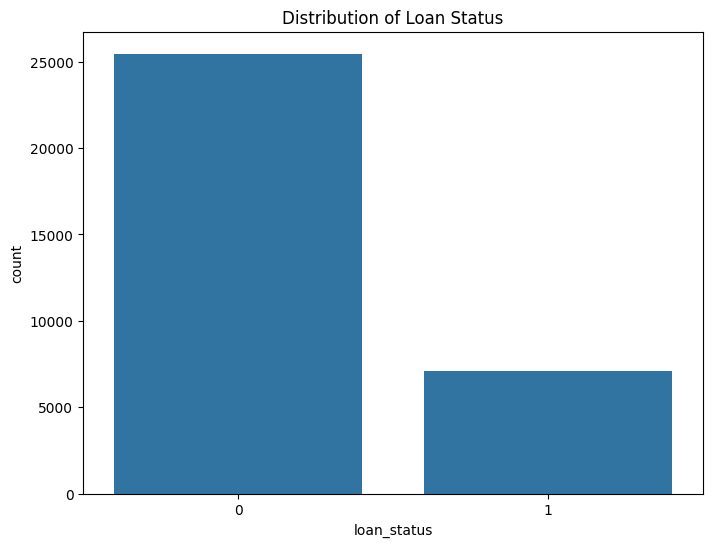

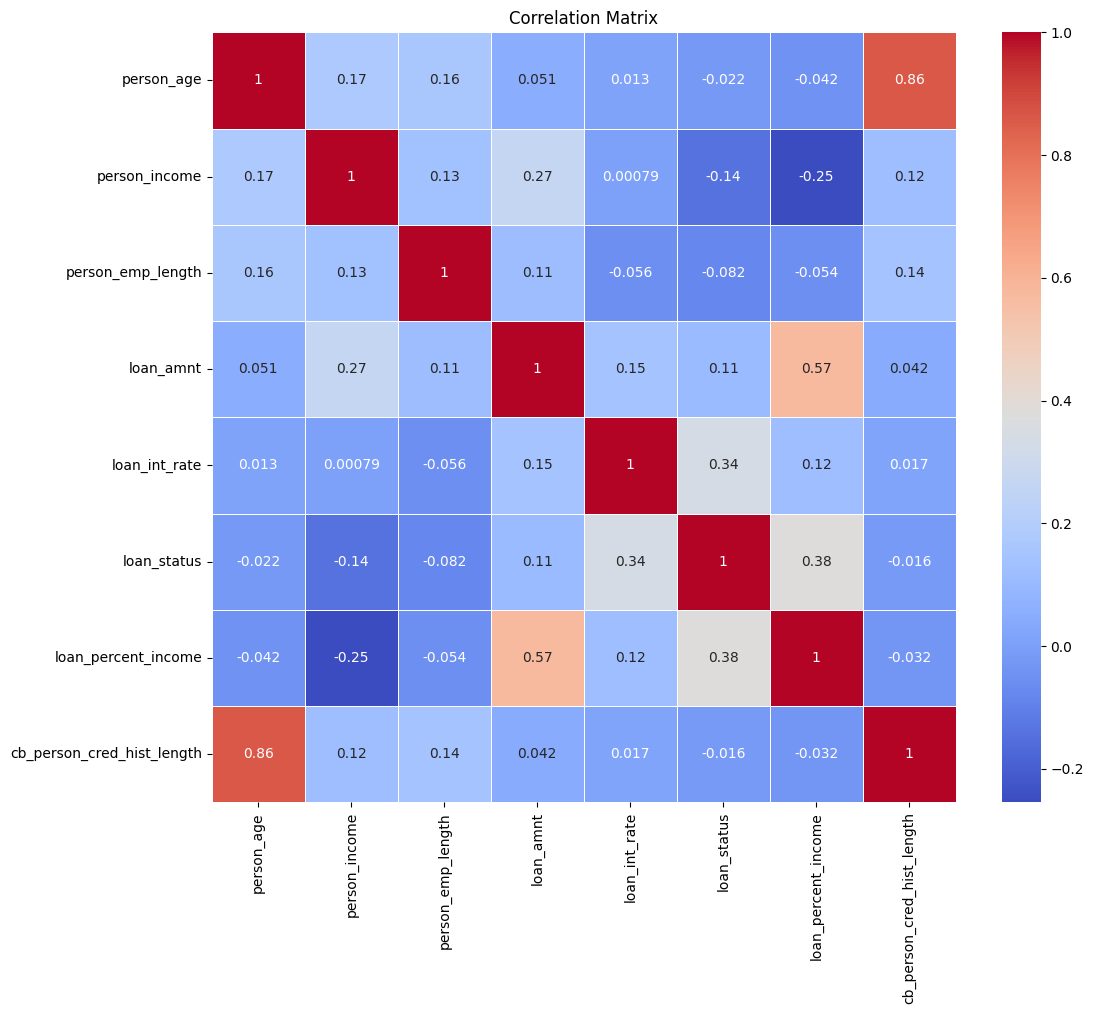

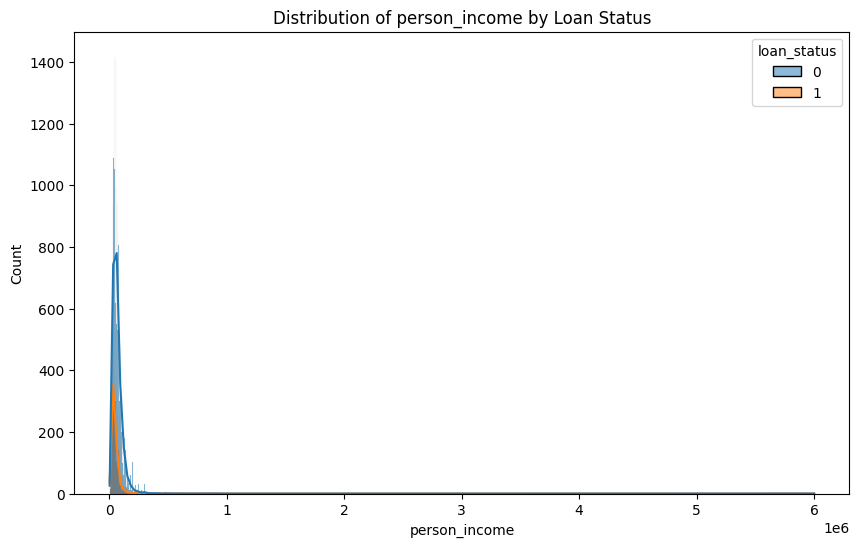

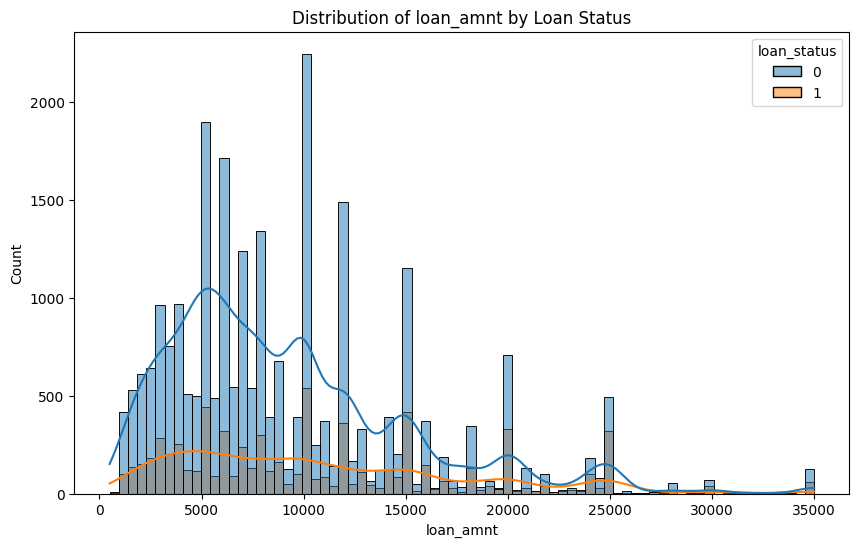

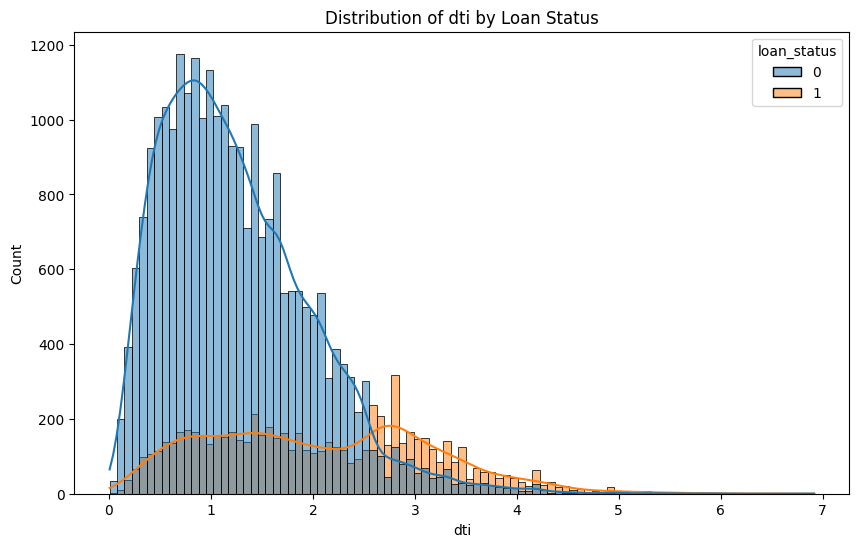

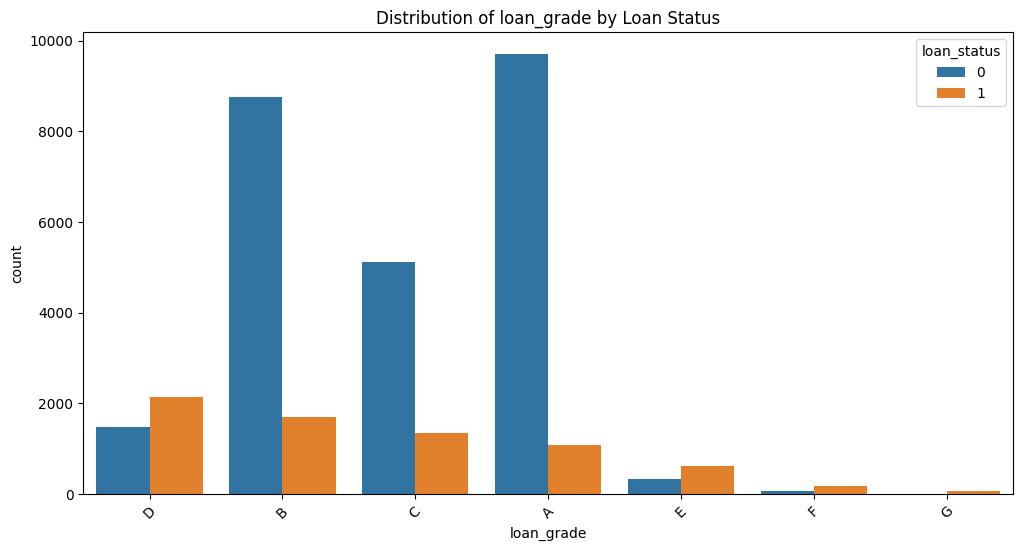

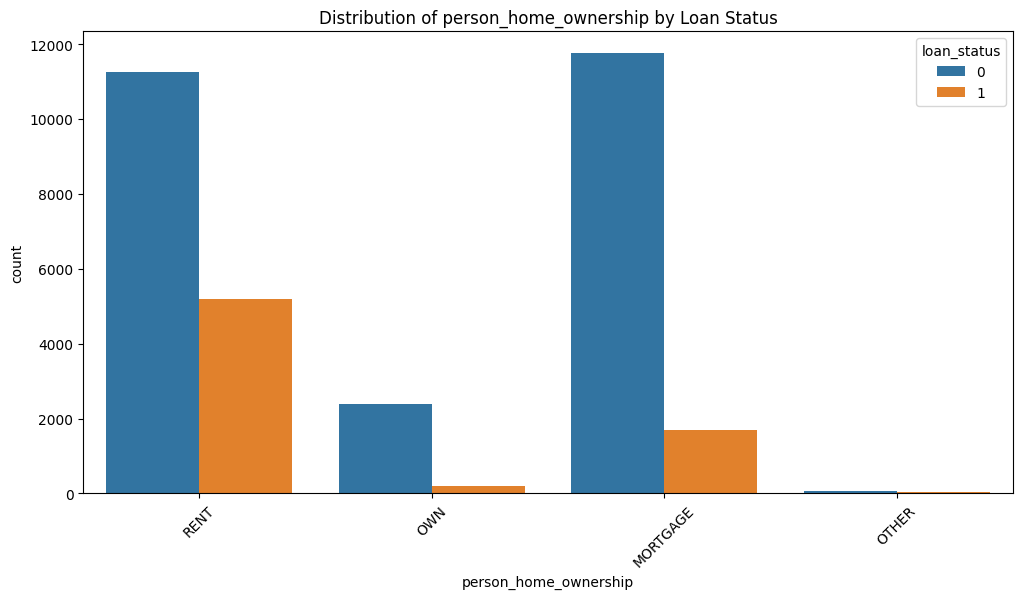

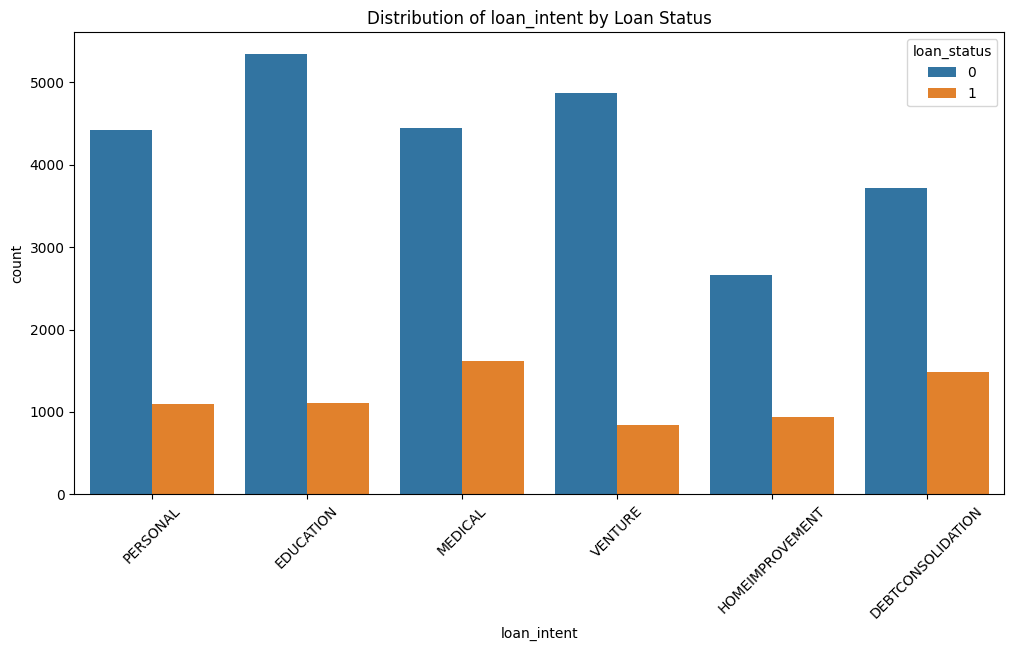

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.show()

# relationships
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# key numerical features
numerical_features = ['person_income', 'loan_amnt', 'dti']
for feature in numerical_features:
    if feature in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=feature, hue='loan_status', kde=True)
        plt.title(f'Distribution of {feature} by Loan Status')
        plt.show()
    else:
        print(f"Feature '{feature}' not found in the DataFrame.")

# key categorical features
categorical_features = ['loan_grade', 'person_home_ownership', 'loan_intent']
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, hue='loan_status', data=df)
    plt.title(f'Distribution of {feature} by Loan Status')
    plt.xticks(rotation=45)
    plt.show()

Data Preprocessing

In [15]:
y = df['loan_status']
X = df.drop('loan_status', axis=1)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Model Building and Evaluation

In [16]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Training
for name, model in models.items():
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      5095
           1       0.78      0.58      0.66      1422

    accuracy                           0.87      6517
   macro avg       0.83      0.77      0.79      6517
weighted avg       0.87      0.87      0.86      6517


Random Forest Results:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.97      0.72      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.86      0.89      6517
weighted avg       0.94      0.93      0.93      6517


Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5095
           1       0.95      0.70      0.81      1422

    accuracy                           0.93      6517
   macro avg       0.94      0.85      0.88   

Model Visualization

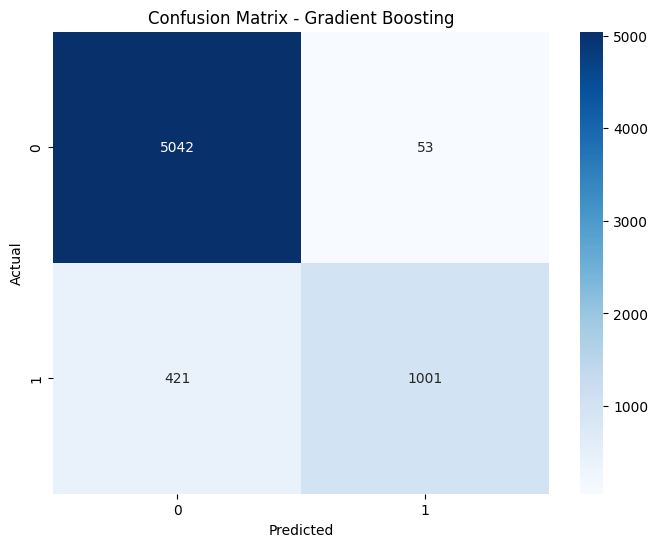

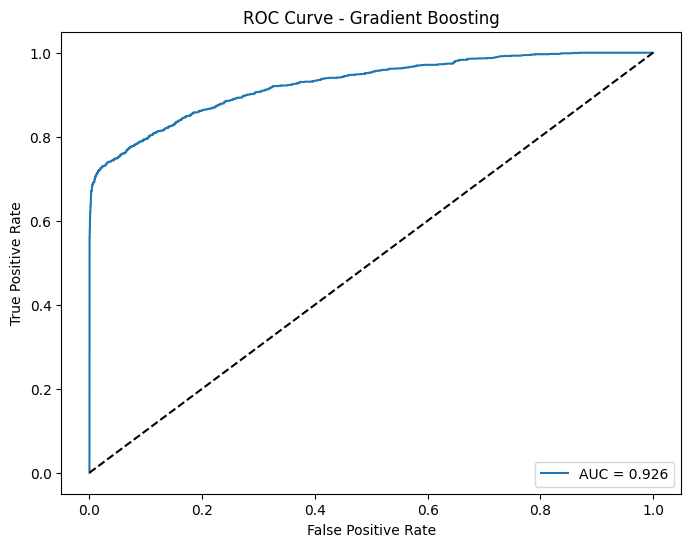

In [17]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {name}')
plt.legend(loc='lower right')
plt.show()

Hyperparameter Tuning

In [18]:
best_model = RandomForestClassifier(random_state=42)

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nTuned Model Results:")
print(classification_report(y_test, y_pred))

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best cross-validation score: 0.933

Tuned Model Results:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.97      0.72      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.86      0.89      6517
weighted avg       0.94      0.93      0.93      6517



Hyperparameter Visuals

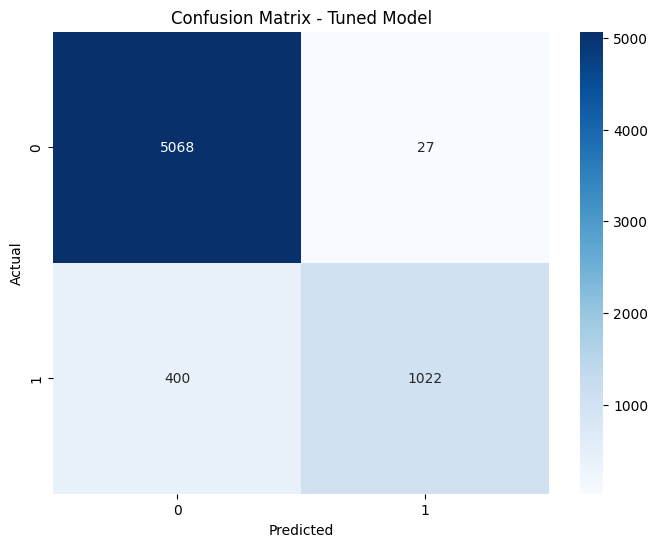

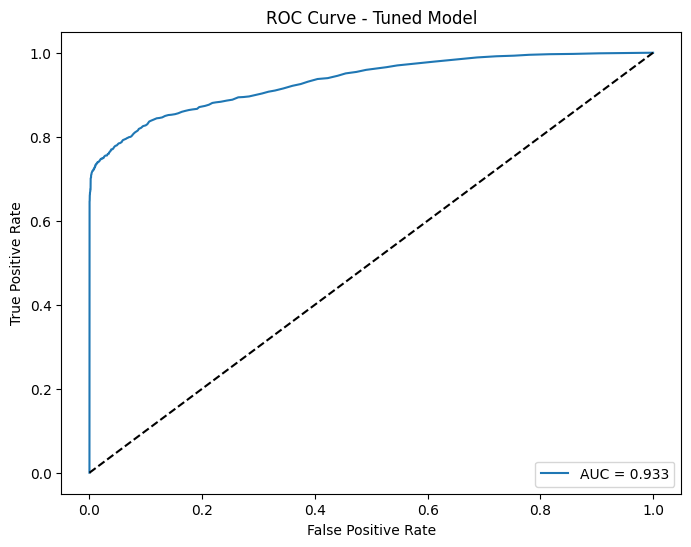

In [19]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Model')
plt.legend(loc='lower right')
plt.show()

Feature Importance

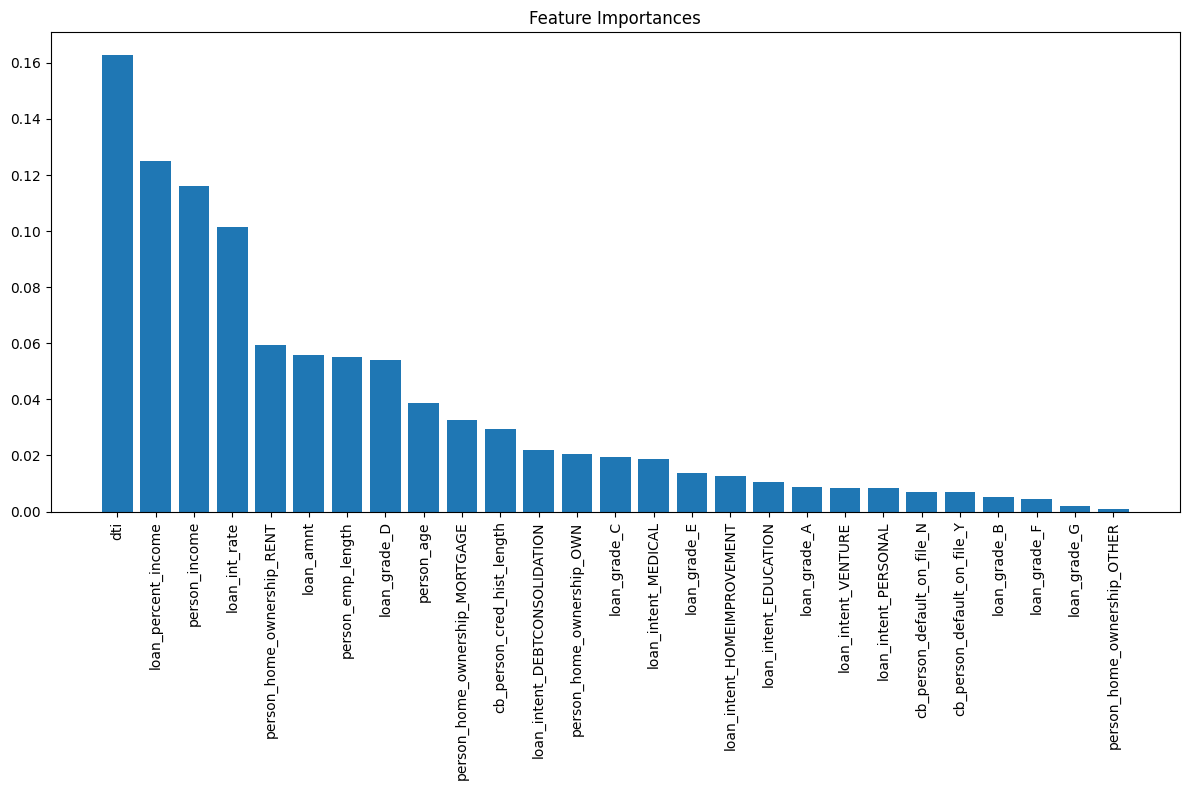

In [20]:
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'cat':
        # Get one-hot encoded feature names
        feature_names.extend(transformer.named_steps['onehot'].get_feature_names_out(features))
    else:
        feature_names.extend(features)

# feature importances
importances = best_pipeline.named_steps['classifier'].feature_importances_

# Sort feature
indices = np.argsort(importances)[::-1]

# Plot 
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Save Model

In [21]:
with open('../models/credit_risk_model.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)

required_features = X.columns.tolist()
with open('../models/required_features.pkl', 'wb') as f:
    pickle.dump(required_features, f)

print("Model and required features saved successfully!")

Model and required features saved successfully!
